# Construct Growth Portfolio Strategy based on Earnings Surprise Factors

## Overview:

This project aims to build growth-oriented portfolio strategy among the S&P500 index universe based on companies' eanings surprises. This project is parallel to the value strategy project using P/B ratio. However, the dataset used here is quite different. Here the dataset is mainly from more structured and cleaned data vendors, including Computstat, CRSP, I/B/E/S, instead of SEC database.  

Techniques used in the project:

1. Using SQL to access various databases, including Compustat, CRSP, I/B/E/S etc.
2. Implementing factor decay to earnings surprises. 

In [ ]:
conn=wrds.Connection()

In [3]:
import pandas as pd
import numpy as np
import wrds
import matplotlib.pyplot as plt
from dateutil.relativedelta import *
import datetime
from pathlib import Path
import pickle 
import copy
import scripts

data_folder_download = './datasets/download/'
data_folder_generate = './datasets/generate/'

## Step 1: Download dataset from Compustat and CRSP

In [3]:
# set sample date range
begdate = '01/01/2013'
enddate = '09/01/2024'

In [95]:
get company identifiers "gvkey', 'iid', 'cik', 'cusip', 'tic' code from compustat
wrds_data = conn.raw_sql("""
                        SELECT DISTINCT c.gvkey, c.iid, c.cik, c.cusip, c.tic
                        FROM comp_na_daily_all.fundq c
                    """)

In [100]:
get 'permco', 'permno', 'cusip' code from crsp
crsp_data = conn.raw_sql("""
                        SELECT DISTINCT a.permco, a.permno, a.cusip
                        FROM crsp_q_stock.msf a
                    """)

In [98]:
# save wrds data to the local csv
wrds_data.to_csv(data_folder_download + 'wrds_data_identifiers.csv', index = False)

In [101]:
# save crsp data to the local csv
crsp_data.to_csv(data_folder_download + 'crsp_data_identifiers.csv', index = False)

In [3]:
wrds_data = pd.read_csv(data_folder_download + 'wrds_data_identifiers.csv')

In [4]:
crsp_data = pd.read_csv(data_folder_download + 'crsp_data_identifiers.csv')

## Step 2: Merge dataset 

In [137]:
# get the sp500_df consituents table with history of removed tickers
# This dataset is previously created from the value_strategy project
with open(data_folder_generate + 'sp500_df_v3.0.pkl', 'rb') as f: 
    sp500_df = pickle.load(f)

In [138]:
# change 'CIK' to float and clean up the sp500_df dataframe 
sp500_df['CIK'] = pd.to_numeric(sp500_df['CIK'], errors = 'coerce')
sp500_df.drop(columns = 'GICS Sub-Industry', inplace = True)
sp500_df.reset_index(inplace = True)

In [113]:
wrds_data['cik'] = pd.to_numeric(wrds_data['cik'], errors = 'coerce')

In [139]:
# merge sp500_df with wrds_data
merged_sp500_df_V1 = pd.merge(left = sp500_df, right = wrds_data, left_on = 'CIK', right_on = 'cik', how = 'left')
merged_sp500_df_V1 = merged_sp500_df_V1.set_index('Ticker')

In [140]:
# drop duplicated tickers based on cik code. 
duplicated_cik_tickers = ['UA', 'NWS', 'GOOGL', 'FOX']
merged_sp500_df_V1 = merged_sp500_df_V1.drop(duplicated_cik_tickers)

In [141]:
merged_sp500_df_V1['cusip'] = merged_sp500_df_V1['cusip'].str.slice(0,8)
merged_sp500_df_V1.head()

,Security,GICS Sector,Date_Added,Date_Removed,Founded,CIK,gvkey,iid,cik,cusip,tic
Ticker,,,,,,,,,,,
A,Agilent Technologies,Health Care,2000-06-05,2024-12-31,1999,1090872,126554,01,1090872.0,00846U10,A
AA,Alcoa,Materials,2000-01-01,2016-11-01,NaN,1675149,27638,01,1675149.0,01387210,AA
AAL,American Airlines Group,Industrials,2015-03-23,2024-12-31,1934,6201,1045,04,6201.0,02376R10,AAL
AAP,Advance Auto Parts,Consumer Discretionary,2015-07-08,2023-08-25,NaN,1158449,145977,01,1158449.0,00751Y10,AAP
AAPL,Apple Inc.,Information Technology,1982-11-30,2024-12-31,1977,320193,1690,01,320193.0,03783310,AAPL


In [117]:
# merge the merged_sp500_df_V1 with the crsp_data
merged_sp500_df_V2 = pd.merge(left = merged_sp500_df_V1, 
                              right = crsp_data, 
                              left_on = 'cusip', right_on = 'cusip', 
                              how = 'left')

In [119]:
# reset tikcr as the index
merged_sp500_df_V2.set_index('tic', inplace = True)
# remove "SW" as there is no permco, permno found, no similiar comnam either in the crsp_q_stock dse table. 
merged_sp500_df_V2[merged_sp500_df_V2.permco.isna()]
merged_sp500_df_V2.drop('SW', inplace = True)

In [143]:
merged_sp500_df_V2.head()

,Security,GICS Sector,Date_Added,Date_Removed,Founded,CIK,gvkey,iid,cik,cusip,permco,permno
tic,,,,,,,,,,,,
A,Agilent Technologies,Health Care,2000-06-05,2024-12-31,1999,1090872,126554,1,1090872.0,00846U10,36364.0,87432.0
AA,Alcoa,Materials,2000-01-01,2016-11-01,NaN,1675149,27638,1,1675149.0,01387210,55718.0,16347.0
AAL,American Airlines Group,Industrials,2015-03-23,2024-12-31,1934,6201,1045,4,6201.0,02376R10,20010.0,21020.0
AAP,Advance Auto Parts,Consumer Discretionary,2015-07-08,2023-08-25,NaN,1158449,145977,1,1158449.0,00751Y10,42402.0,89217.0
AAPL,Apple Inc.,Information Technology,1982-11-30,2024-12-31,1977,320193,1690,1,320193.0,03783310,7.0,14593.0


In [229]:
# get a list of sp500 tickers.
sp500_tickers_list = merged_sp500_df_V2.index.to_list()

# convert cusip to str for the link with ibes data
merged_sp500_df_V2['cusip'] = merged_sp500_df_V2['cusip'].astype(str)

In [11]:
# NOTE THERE IS NO DATA AVAILABLE FOR TICKER ['BIGGQ', 'GAP', 'SAIH', 'STI'] FOR IBES BASED ON CUSIP
no_ibes_tickers_list = [ticker for ticker in eps_con_ests if eps_con_ests[ticker].empty]

# trouble shoot, identified [BIG, GSP] as the oftic in ibes for ['BIG', 'GSP'], update the dataframe
merged_sp500_df_V3 = merged_sp500_df_V2.rename(index = {'BIGGQ': 'BIG'}).drop(['SAIH', 'STI', 'GAP'])

# update the sp500_tickers_list
sp500_tickers_list_v2 = merged_sp500_df_V3.index.to_list()

In [231]:
merged_sp500_df_V3.to_csv(data_folder_generate + 'merged_sp500_df.csv')

In [10]:
merged_sp500_df_V3 = pd.read_csv(data_folder_generate + 'merged_sp500_df.csv', index_col = 'tic')

## Step 3: Download consensus estiamtes of historical EPS from I/B/E/S database  

In [160]:
# create consensus eps estimates dict:
eps_con_ests = {}

# download all the consensus eps ests for sp500 constituents:
for ticker in sp500_tickers_list_v2: 
    ticker_cusip = merged_sp500_df_V3.loc[ticker, 'cusip']
    eps_con_ests[ticker] = conn.raw_sql(
        f"""
            SELECT Oftic, cusip, statpers, measure, Fiscalp, Estflag, Numest, Numup, Numdown, Medest, Meanest, Stdev, 
            Fpedats, Actual, Actdats_act, Acttims_act, Anndats_act, Anntims_act
            FROM tr_ibes.statsum_epsus
            WHERE cusip = '{ticker_cusip}' AND '{ticker}' = oftic
            AND fpedats BETWEEN '{begdate}' AND '{enddate}'
        """, date_cols = ['statpers', 'Fpedats', 'Actdats_act', 'Anndats_act']
    )

In [238]:
with open(data_folder_download + 'eps_con_ests_V1.0.pkl', 'wb') as f: 
    pickle.dump(eps_con_ests, f)

In [5]:
with open(data_folder_download + 'eps_con_ests_V1.0.pkl', 'rb') as f: 
    eps_con_ests = pickle.load(f)

## Step 4: Filter out the most recent quarterly estimates before the EAD

In [240]:
# filter dates to get the most recent quarterly estimates before the EAD. 
recent_eps_con_ests = {}
merged_recent_eps_con_ests = {}
for ticker in sp500_tickers_list_v2:
    eps_con_ests[ticker]['fpedats'] = pd.to_datetime(eps_con_ests[ticker]['fpedats'])
    eps_con_ests[ticker]['anndats_act'] = pd.to_datetime(eps_con_ests[ticker]['anndats_act'])
    # identify the dates for the most recent concensus review and calculation
    recent_eps_con_ests[ticker] = eps_con_ests[ticker].groupby(['anndats_act']).statpers.max().reset_index()
    # filter out annual estimates and only keep the most estimates for the most recent quarters.
    eps_con_ests[ticker] = eps_con_ests[ticker].query('fiscalp == "QTR" and (fpedats - statpers).dt.days <=20')
    # join above two tables to get the most recent EPS estimates for the upcoming quarters.
    merged_recent_eps_con_ests[ticker] = pd.merge(left = recent_eps_con_ests[ticker], right = eps_con_ests[ticker], on = 'statpers', how = 'left')

In [241]:
# calculate earnings surprise
for ticker in sp500_tickers_list_v2:
    merged_recent_eps_con_ests[ticker]
    df = merged_recent_eps_con_ests[ticker]
    df.loc[:, 'surprise'] = df.loc[:, 'actual']/df.loc[:, 'meanest'] - 1
    merged_recent_eps_con_ests[ticker] = df.rename(columns = {'anndats_act_x': 'anndats_act'})
    merged_recent_eps_con_ests[ticker].set_index('fpedats', inplace = True)

In [242]:
eps_con_ests_df = pd.concat(merged_recent_eps_con_ests, axis = 0)

In [243]:
with open(data_folder_generate + 'eps_con_ests_dfV1.0.pkl', 'wb') as f: 
    pickle.dump(eps_con_ests_df, f)

In [6]:
with open(data_folder_generate + 'eps_con_ests_dfV1.0.pkl', 'rb') as f: 
    eps_con_ests_df = pickle.load(f)

## Step 5: Calculate the factor decay of earnings surprise

In [8]:
eps_con_ests_df = eps_con_ests_df.reset_index()

In [9]:
eps_con_ests_df['anndats_act_month_end'] = eps_con_ests_df['anndats_act'].apply(lambda x: pd.offsets.MonthEnd().rollforward(x))

In [10]:
eps_con_ests_df.rename(columns = {'level_0': 'ticker'}, inplace = True)

In [11]:
# set daily_decay_factor at -1.5%, post earnings announcement drift have an average impact duration of 60 days. 
# According to Bernard, V. L., & Thomas, J. K. (1990), 
# Evidence that stock prices do not fully reflect the implications of current earnings for future earningsm. Journal of Accounting and Economics, 13(4), 305-340
daily_decay_factor = -0.015
eps_con_ests_df['decay'] = 1 + ((eps_con_ests_df['anndats_act_month_end'] - eps_con_ests_df['anndats_act']).dt.days)*daily_decay_factor

In [12]:
eps_con_ests_df['decay'].describe()

count    23945.000000
mean         0.804585
std          0.147635
min          0.550000
25%          0.655000
50%          0.850000
75%          0.940000
max          1.000000
Name: decay, dtype: float64

In [13]:
monthly_decay_df = eps_con_ests_df.groupby(['anndats_act_month_end', 'ticker'])['decay'].last().reset_index()

In [14]:
monthly_decay_df.head()

,anndats_act_month_end,ticker,decay
0,2013-02-28,A,0.790
1,2013-02-28,ADI,0.880
2,2013-02-28,ADSK,0.955
3,2013-02-28,AMAT,0.775
4,2013-02-28,ANF,0.910


In [15]:
monthly_df = eps_con_ests_df.groupby(['anndats_act_month_end', 'ticker'])['surprise'].last().reset_index()

In [16]:
monthly_df.head()

,anndats_act_month_end,ticker,surprise
0,2013-02-28,A,-0.045455
1,2013-02-28,ADI,-0.022222
2,2013-02-28,ADSK,0.081633
3,2013-02-28,AMAT,0.500000
4,2013-02-28,ANF,0.133333


### Step 5.1 Use pivot() to re-structure of the dataframe

In [17]:
monthly_decay_df_pivot = monthly_decay_df.pivot(index = 'anndats_act_month_end', columns = 'ticker', values = 'decay')

In [18]:
monthly_df_pivot = monthly_df.pivot(index = 'anndats_act_month_end', columns = 'ticker', values = 'surprise')

In [19]:
monthly_df_pivot.head()

ticker,A,AA,AAL,AAP,AAPL,ABBV,ABNB,ABT,ACGL,ACN,...,XEL,XOM,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZION,ZTS
anndats_act_month_end,,,,,,,,,,,,,,,,,,,,,
2013-02-28,-0.045455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.030928,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-30,NaN,NaN,NaN,NaN,0.001111,0.030303,NaN,0.02439,0.21875,NaN,...,NaN,0.039216,NaN,NaN,0.0,0.166667,NaN,NaN,0.307692,0.090909
2013-05-31,0.132353,NaN,NaN,0.018519,NaN,NaN,NaN,NaN,NaN,NaN,...,0.116279,NaN,NaN,NaN,NaN,NaN,NaN,-0.269841,NaN,NaN
2013-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.008850,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
monthly_decay_df_pivot.head()

ticker,A,AA,AAL,AAP,AAPL,ABBV,ABNB,ABT,ACGL,ACN,...,XEL,XOM,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZION,ZTS
anndats_act_month_end,,,,,,,,,,,,,,,,,,,,,
2013-02-28,0.790,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.955,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-30,NaN,NaN,NaN,NaN,0.895,0.94,NaN,0.805,0.985,NaN,...,NaN,0.925,NaN,NaN,1.0,0.895,NaN,NaN,0.88,1.0
2013-05-31,0.745,NaN,NaN,0.88,NaN,NaN,NaN,NaN,NaN,NaN,...,0.565,NaN,NaN,NaN,NaN,NaN,NaN,0.565,NaN,NaN
2013-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.955,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
# Define the decay factors as a list for each NaN encounter
decay_factors = [30*(-0.015), 60*(-0.015)]  # decay at a rate of -1.5%/per day

def forward_fill_with_decay(df, decay_factors):
    # Iterate over each column (ticker in this case)
    for col in df.columns:
        # Keep track of the last valid value and how many consecutive NaNs we've encountered
        last_valid_value = np.nan
        nan_count = 0
        
        # Iterate through the rows of each column
        for i in range(len(df[col])):
            if pd.notna(df[col].iloc[i]):  # If the current value is valid (not NaN)
                last_valid_value = df[col].iloc[i]
                nan_count = 0  # Reset the NaN count
            else:
                if last_valid_value is not np.nan:
                    # Apply the decay factor depending on the NaN count
                    if nan_count < len(decay_factors):
                        # Apply the appropriate decay factor for the current NaN
                        df[col].iloc[i] = max(last_valid_value * (1+decay_factors[nan_count]), 0) if last_valid_value > 0 else min(last_valid_value * (1+decay_factors[nan_count]), 0)
                    else:
                        # If we have more NaNs than decay factors, don't fill or apply the last factor
                        df[col].iloc[i] = max(last_valid_value * (1+decay_factors[-1]), 0) if last_valid_value > 0 else min(last_valid_value * (1+decay_factors[nan_count]), 0)
                    nan_count += 1

    return df

In [ ]:
# Apply the forward fill with decay factors
monthly_decay_df_pivot_V2 = forward_fill_with_decay(monthly_decay_df_pivot.copy(), decay_factors)

# Display the result
monthly_decay_df_pivot_V2.head()

In [23]:
monthly_df_pivot = monthly_df_pivot.ffill()

In [24]:
monthly_df_pivot.head()

ticker,A,AA,AAL,AAP,AAPL,ABBV,ABNB,ABT,ACGL,ACN,...,XEL,XOM,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZION,ZTS
anndats_act_month_end,,,,,,,,,,,,,,,,,,,,,
2013-02-28,-0.045455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-03-31,-0.045455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.030928,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-30,-0.045455,NaN,NaN,NaN,0.001111,0.030303,NaN,0.02439,0.21875,0.030928,...,NaN,0.039216,NaN,NaN,0.0,0.166667,NaN,NaN,0.307692,0.090909
2013-05-31,0.132353,NaN,NaN,0.018519,0.001111,0.030303,NaN,0.02439,0.21875,0.030928,...,0.116279,0.039216,NaN,NaN,0.0,0.166667,NaN,-0.269841,0.307692,0.090909
2013-06-30,0.132353,NaN,NaN,0.018519,0.001111,0.030303,NaN,0.02439,0.21875,0.008850,...,0.116279,0.039216,NaN,NaN,0.0,0.166667,NaN,-0.269841,0.307692,0.090909


## Step 6: Calculate the monthly earnings surprise factoring in monthly decay factors  

In [25]:
monthly_surprise_df_pivot = monthly_df_pivot * monthly_decay_df_pivot_V2

In [26]:
# start date from 2013-04-30 since this is the month where majority of the companies has reported their earnings. 
monthly_surprise_df_pivot = monthly_surprise_df_pivot.iloc[2:]
monthly_surprise_df_pivot.head()

ticker,A,AA,AAL,AAP,AAPL,ABBV,ABNB,ABT,ACGL,ACN,...,XEL,XOM,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZION,ZTS
anndats_act_month_end,,,,,,,,,,,,,,,,,,,,,
2013-04-30,-0.003591,NaN,NaN,NaN,0.000994,0.028485,NaN,0.019634,0.215469,0.016245,...,NaN,0.036275,NaN,NaN,0.000000,0.149167,NaN,NaN,0.270769,0.090909
2013-05-31,0.098603,NaN,NaN,0.016296,0.000547,0.015667,NaN,0.010799,0.118508,0.002954,...,0.065698,0.019951,NaN,NaN,0.000000,0.082042,NaN,-0.152460,0.148923,0.050000
2013-06-30,0.054232,NaN,NaN,0.008963,0.000099,0.002848,NaN,0.001963,0.021547,0.008451,...,0.036134,0.003627,NaN,NaN,0.000000,0.014917,NaN,-0.083853,0.027077,0.009091
2013-07-31,0.009860,NaN,NaN,0.001630,0.023015,0.035127,NaN,0.035909,0.162500,0.004648,...,0.006570,0.003627,NaN,NaN,-0.179091,0.025370,NaN,-0.015246,0.063293,0.009091
2013-08-31,0.072097,NaN,NaN,0.043960,0.012658,0.019320,NaN,0.019750,0.089375,0.000845,...,0.014103,-0.101316,NaN,NaN,-0.098500,0.013954,NaN,-0.029762,0.034811,0.000000


## Step 7: Calculate the monthly earnings surprise factoring in monthly decay factors  

In [266]:
monthly_surprise_ranking_df = monthly_surprise_df_pivot.rank(axis = 1)

In [267]:
monthly_surprise_ranking_df.head()

ticker,A,AA,AAL,AAP,AAPL,ABBV,ABNB,ABT,ACGL,ACN,...,XEL,XOM,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZION,ZTS
anndats_act_month_end,,,,,,,,,,,,,,,,,,,,,
2013-04-30,72.0,NaN,NaN,NaN,105.0,179.0,NaN,161.0,290.0,148.0,...,NaN,188.5,NaN,NaN,89.5,268.5,NaN,NaN,297.0,238.0
2013-05-31,379.0,NaN,NaN,237.0,156.0,233.0,NaN,207.0,389.0,166.0,...,335.0,250.5,NaN,NaN,138.0,356.5,NaN,20.0,401.0,315.0
2013-06-30,398.0,NaN,NaN,274.0,156.0,201.0,NaN,184.0,346.0,269.0,...,374.0,211.5,NaN,NaN,136.5,312.5,NaN,12.0,362.0,277.0
2013-07-31,232.0,NaN,NaN,184.0,272.0,297.0,NaN,298.0,396.0,211.0,...,216.0,204.5,NaN,NaN,21.0,278.0,NaN,78.0,342.0,228.0
2013-08-31,367.0,NaN,NaN,316.0,209.0,240.0,NaN,241.0,379.0,162.0,...,218.0,29.0,NaN,NaN,31.0,216.0,NaN,73.0,295.0,144.0


In [270]:
with open(data_folder_generate + 'monthly_surprise_ranking_df.pkl', 'wb') as f: 
    pickle.dump(monthly_surprise_ranking_df, f)

In [5]:
with open(data_folder_generate + 'monthly_surprise_ranking_df.pkl', 'rb') as f: 
    monthly_surprise_ranking_df = pickle.load(f)

## Step 8: Create the monthly availability table for all the tickers from 2013 to current

In [28]:
# Step 1: Convert date columns to datetime if not already
merged_sp500_df_V3['Date_Added'] = pd.to_datetime(merged_sp500_df_V3['Date_Added'])
merged_sp500_df_V3['Date_Removed'] = pd.to_datetime(merged_sp500_df_V3['Date_Removed'])
monthly_availability_df = copy.deepcopy(monthly_surprise_ranking_df)

# Step 3: Iterate through each column in monthly_surprise_ranking_df
for ticker in monthly_availability_df.columns:
        date_added = merged_sp500_df_V3.at[ticker, 'Date_Added']
        date_removed = merged_sp500_df_V3.at[ticker, 'Date_Removed']
        
        # Apply the condition and set flags for each date in the index
        monthly_availability_df[ticker] = monthly_availability_df.index.map(
            lambda date: 1 if (date_added <= date <= date_removed) else np.nan
        )


In [297]:
monthly_availability_df.head()

ticker,A,AA,AAL,AAP,AAPL,ABBV,ABNB,ABT,ACGL,ACN,...,XEL,XOM,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZION,ZTS
anndats_act_month_end,,,,,,,,,,,,,,,,,,,,,
2013-04-30,1,1.0,NaN,NaN,1,1,NaN,1,NaN,1,...,1,1,1.0,1.0,1,1,1,NaN,1.0,NaN
2013-05-31,1,1.0,NaN,NaN,1,1,NaN,1,NaN,1,...,1,1,1.0,1.0,1,1,1,NaN,1.0,NaN
2013-06-30,1,1.0,NaN,NaN,1,1,NaN,1,NaN,1,...,1,1,1.0,1.0,1,1,1,NaN,1.0,1.0
2013-07-31,1,1.0,NaN,NaN,1,1,NaN,1,NaN,1,...,1,1,1.0,1.0,1,1,1,NaN,1.0,1.0
2013-08-31,1,1.0,NaN,NaN,1,1,NaN,1,NaN,1,...,1,1,1.0,1.0,1,1,1,NaN,1.0,1.0


In [298]:
with open(data_folder_generate + 'monthly_availability_df.pkl', 'wb') as f: 
    pickle.dump(monthly_availability_df, f)

In [4]:
with open(data_folder_generate + 'monthly_availability_df.pkl', 'rb') as f: 
    monthly_availability_df = pickle.load(f)

## Step 9: Calculate the monthly weightings among stocks

In [8]:
monthly_top_20_weighting_df, monthly_bottom_20_weighting_df = scripts.weighting(monthly_surprise_ranking_df, monthly_availability_df) 

In [303]:
monthly_top_20_weighting_df

ticker,A,AA,AAL,AAP,AAPL,ABBV,ABNB,ABT,ACGL,ACN,...,XEL,XOM,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZION,ZTS
anndats_act_month_end,,,,,,,,,,,,,,,,,,,,,
2013-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.020833,NaN,NaN,0.020833,NaN
2013-05-31,0.015873,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.015873,NaN,NaN,0.015873,NaN
2013-06-30,0.015873,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.015873,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.015873,NaN
2013-07-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-08-31,0.015625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-30,NaN,NaN,0.010309,NaN,NaN,NaN,NaN,NaN,0.010309,NaN,...,0.010309,NaN,NaN,NaN,NaN,NaN,NaN,0.010309,NaN,NaN
2024-05-31,NaN,NaN,0.010204,NaN,NaN,NaN,0.010204,NaN,0.010204,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-06-30,NaN,NaN,NaN,NaN,NaN,NaN,0.010204,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [308]:
merged_sp500_df_V3.head()

,Security,GICS Sector,Date_Added,Date_Removed,Founded,CIK,gvkey,iid,cik,cusip,permco,permno
tic,,,,,,,,,,,,
A,Agilent Technologies,Health Care,2000-06-05,2024-12-31,1999,1090872,126554,1,1090872.0,00846U10,36364.0,87432.0
AA,Alcoa,Materials,2000-01-01,2016-11-01,NaN,1675149,27638,1,1675149.0,01387210,55718.0,16347.0
AAL,American Airlines Group,Industrials,2015-03-23,2024-12-31,1934,6201,1045,4,6201.0,02376R10,20010.0,21020.0
AAP,Advance Auto Parts,Consumer Discretionary,2015-07-08,2023-08-25,NaN,1158449,145977,1,1158449.0,00751Y10,42402.0,89217.0
AAPL,Apple Inc.,Information Technology,1982-11-30,2024-12-31,1977,320193,1690,1,320193.0,03783310,7.0,14593.0


In [322]:
merged_sp500_df_V3.permco.astype(int,)
merged_sp500_df_V3.permno.astype(int,)

tic
A       87432
AA      16347
AAL     21020
AAP     89217
AAPL    14593
        ...  
YUM     85348
ZBH     89070
ZBRA    76795
ZION    84129
ZTS     13788
Name: permno, Length: 595, dtype: int32

In [324]:
merged_sp500_df_V3['permno']

tic
A       87432.0
AA      16347.0
AAL     21020.0
AAP     89217.0
AAPL    14593.0
         ...   
YUM     85348.0
ZBH     89070.0
ZBRA    76795.0
ZION    84129.0
ZTS     13788.0
Name: permno, Length: 595, dtype: float64

## Step 10: Get the price data from CRSP database

In [332]:
price_df_crsp = {}

for ticker in merged_sp500_df_V3.index: 
    permco = int(merged_sp500_df_V3.at[ticker, 'permco'])
    permno = int(merged_sp500_df_V3.at[ticker, 'permno'])
    price_df_crsp[ticker] = conn.raw_sql(f"""
                                SELECT date, permco, permno, prc, vol
                                FROM crsp_q_stock.dsf c
                                WHERE c.permco = '{permco}' AND c.permno = '{permno}'
                                AND date BETWEEN '{begdate}' AND '{enddate}'
    """)

In [335]:
with open(data_folder_download + 'price_df_crsp.pkl', 'wb') as f:
    pickle.dump(price_df_crsp, f)

In [7]:
with open(data_folder_download + 'price_df.pkl', 'rb') as f:
    price_df = pickle.load(f)

In [12]:
price_df = price_df[sp500_tickers_list_v2]

## Step 11: Calculate stock monthly returns

In [13]:
monthly_returns_df = price_df/price_df.shift(1) - 1
monthly_returns_df = monthly_returns_df.iloc[1:] 

In [15]:
monthly_returns_df.head()

,A,AA,AAL,AAP,AAPL,ABBV,ABNB,ABT,ACGL,ACN,...,XEL,XOM,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2013-04-30,-0.012628,-0.002347,-0.004125,0.014882,0.000271,0.139681,NaN,0.049260,0.009321,0.083519,...,0.070370,-0.012429,-0.002120,-0.002326,0.006894,-0.048327,0.016352,-0.010185,-0.014806,-0.009405
2013-05-31,0.096766,0.003394,0.039646,-0.028135,0.022419,-0.072964,NaN,-0.006771,-0.034866,0.008226,...,-0.096571,0.023664,-0.013931,0.024475,0.018136,-0.005431,0.026945,-0.021222,0.141779,-0.030890
2013-06-30,-0.056558,-0.080000,-0.065453,-0.003579,-0.118293,-0.031623,NaN,-0.048814,0.003906,-0.123615,...,-0.003769,-0.001327,-0.017619,0.038570,-0.042644,0.023469,-0.042918,-0.048620,0.030281,-0.034688
2013-07-31,0.046071,0.016623,0.178441,0.016262,0.141225,0.110259,NaN,0.054421,0.053686,0.025709,...,0.056811,0.037631,0.046875,0.069459,-0.074610,0.056477,0.113958,0.062845,0.024896,-0.032873
2013-08-31,0.042701,-0.027759,-0.164858,-0.029336,0.083767,-0.063105,NaN,-0.090090,-0.015876,-0.021136,...,-0.067780,-0.063867,-0.020756,0.028866,-0.001374,-0.039769,-0.052587,-0.012346,-0.055026,-0.022140


In [16]:
with open(data_folder_generate + 'monthly_returns_df.pkl', 'wb') as f:
    pickle.dump(monthly_returns_df, f)

In [6]:
with open(data_folder_generate + 'monthly_returns_df.pkl', 'rb') as f:
    monthly_returns_df = pickle.load(f)

## Step 12: Draw cumulative portfolio returns for the top 20% and bottom 20% stocks.

In [9]:
top_20_weighted_cum_returns, bottom_20_weighted_cum_returns, long_short_pb_cum_returns = scripts.cal_cum_rets(monthly_top_20_weighting_df, monthly_bottom_20_weighting_df, monthly_returns_df, long = 'high')

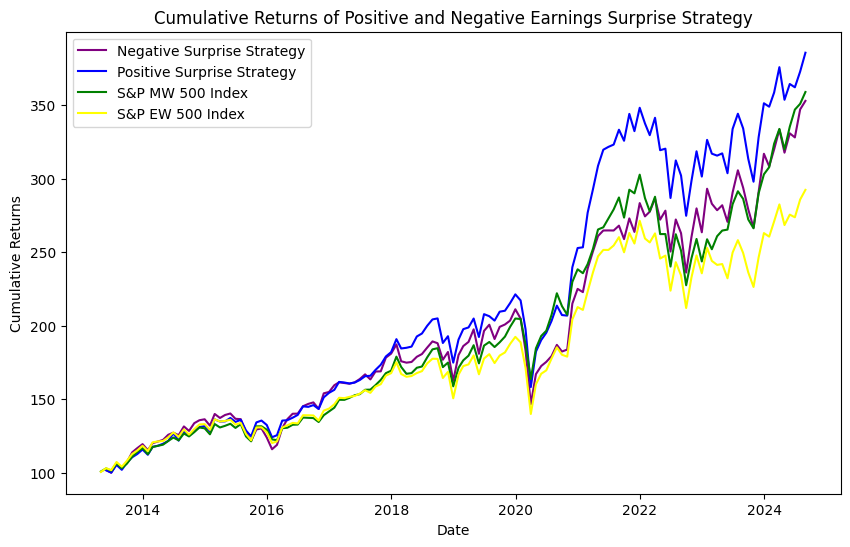

In [12]:
# Visualize the cumulative returns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
#plt.plot(long_short_pb_cumulative_returns, label='Long-Short Price/BVPS Strategy', color = 'orange')
plt.plot(bottom_20_weighted_cum_returns, label='Negative Surprise Strategy', color = 'purple')
plt.plot(top_20_weighted_cum_returns, label='Positive Surprise Strategy', color = 'blue')
plt.plot(sp500_mw_cum_rets, label='S&P MW 500 Index', color = 'green')
plt.plot(sp500_ew_cum_rets, label='S&P EW 500 Index', color = 'yellow')
plt.title('Cumulative Returns of Positive and Negative Earnings Surprise Strategy')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()

In [11]:
#calculate the cum returns for indexes
sp500_ew_cum_rets = scripts.cal_index_cum_rets('^SPXEW', data_folder_download)
sp500_mw_cum_rets = scripts.cal_index_cum_rets('^GSPC', data_folder_download)

## Step 13: Draw relative portfolio performance of negative/positive earnings surprise to SP500 index.

In [21]:
neg_surp_cumulative_returns_relative = bottom_20_weighted_cum_returns / sp500_ew_cum_rets['Adj Close']
pos_surp_cumulative_returns_relative = top_20_weighted_cum_returns / sp500_ew_cum_rets['Adj Close']

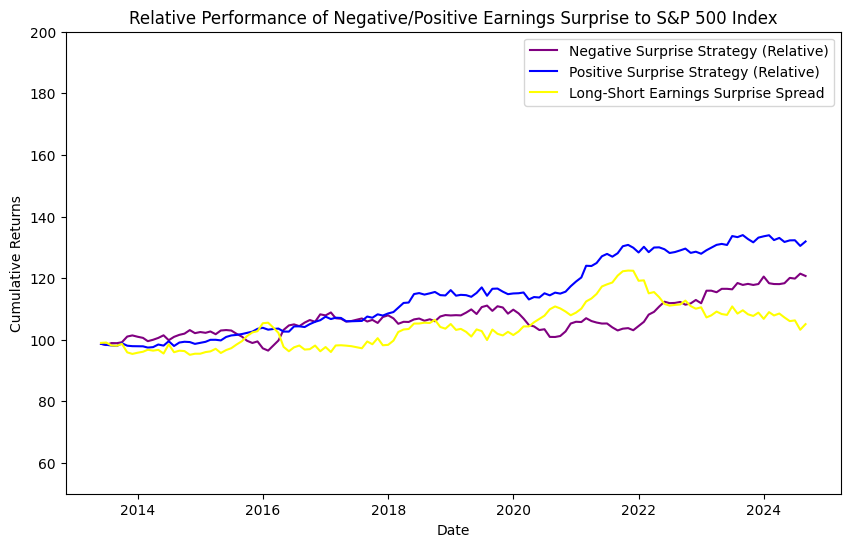

In [22]:
plt.figure(figsize=(10, 6))

plt.plot(neg_surp_cumulative_returns_relative*100, label='Negative Surprise Strategy (Relative)', color = 'purple')
plt.plot(pos_surp_cumulative_returns_relative*100, label='Positive Surprise Strategy (Relative)', color = 'blue')
plt.plot(long_short_pb_cum_returns, label='Long-Short Earnings Surprise Spread', color = 'yellow')
plt.title('Relative Performance of Negative/Positive Earnings Surprise to S&P 500 Index')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.ylim(50, 200)
# Show the plot with annotations
plt.show()

## Step 14:  Analysis of the results

### Step 14.1: Average rolling 12-month returns and volatilities

In [16]:
bottom_20_monthly_return = ((monthly_bottom_20_weighting_df.shift(1) * monthly_returns_df).sum(axis = 1)).iloc[1:]
top_20_monthly_return = ((monthly_top_20_weighting_df.shift(1) * monthly_returns_df).sum(axis = 1)).iloc[1:]

bottom_20_rolling_12mon_return, bottom_20_rolling_12mon_vol = scripts.calc_rolling_12mon_return_n_vol(bottom_20_monthly_return)
top_20_rolling_12mon_return, top_20_rolling_12mon_vol = scripts.calc_rolling_12mon_return_n_vol(top_20_monthly_return)

In [17]:
bottom_20_rolling_12mon_return_mean = bottom_20_rolling_12mon_return.mean()
bottom_20_rolling_12mon_vol_mean = bottom_20_rolling_12mon_vol.mean()
top_20_rolling_12mon_return_mean = top_20_rolling_12mon_return.mean()
top_20_rolling_12mon_vol_mean = top_20_rolling_12mon_vol.mean()

In [18]:
mw_index_monthly_return = scripts.calc_index_monthly_returns('^GSPC', data_folder_download)
ew_index_monthly_return = scripts.calc_index_monthly_returns('^SPXEW', data_folder_download)

In [20]:
mw_index_rolling_12mon_return, mw_index_rolling_12mon_vol = scripts.calc_rolling_12mon_return_n_vol(mw_index_monthly_return)
ew_index_rolling_12mon_return, ew_index_rolling_12mon_vol = scripts.calc_rolling_12mon_return_n_vol(ew_index_monthly_return)

mw_index_rolling_12mon_return_mean = mw_index_rolling_12mon_return.mean()
mw_index_rolling_12mon_vol_mean = mw_index_rolling_12mon_vol.mean()
ew_index_rolling_12mon_return_mean = ew_index_rolling_12mon_return.mean()
ew_index_rolling_12mon_vol_mean = ew_index_rolling_12mon_vol.mean()

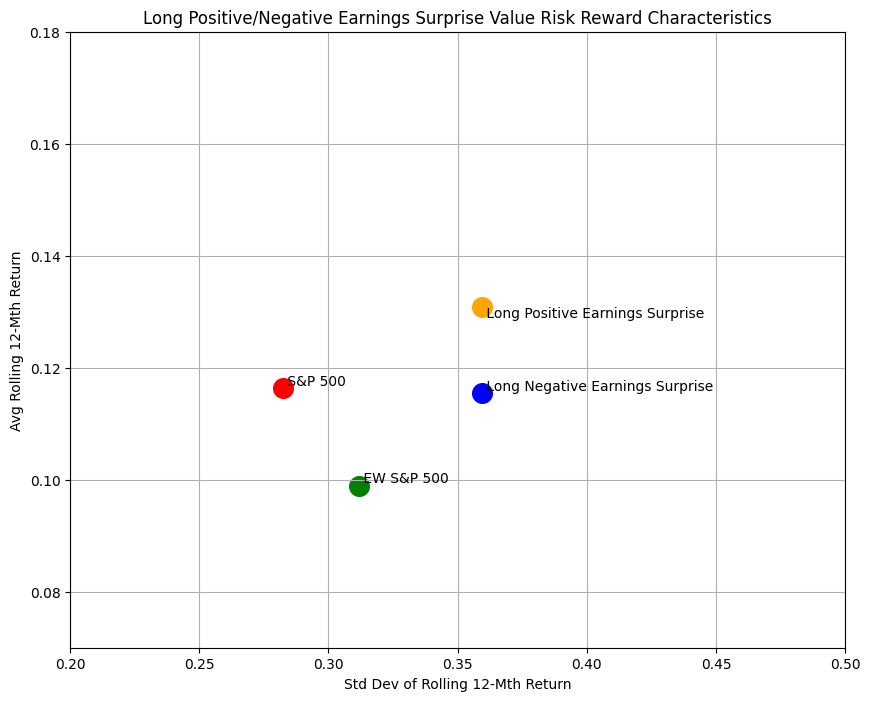

In [22]:
# Data points from the provided images
# Replace these with your actual calculated mean and standard deviation values
returns = {
    'Long negative earnings surprise': bottom_20_rolling_12mon_return_mean,
    'Long positive earnings surprise': top_20_rolling_12mon_return_mean,
    'EW S&P 500': ew_index_rolling_12mon_return_mean,
    'S&P 500': mw_index_rolling_12mon_return_mean
}

std_devs = {
    'Long negative earnings surprise': bottom_20_rolling_12mon_vol_mean,
    'Long positive earnings surprise': top_20_rolling_12mon_vol_mean,
    'EW S&P 500': ew_index_rolling_12mon_vol_mean,
    'S&P 500': mw_index_rolling_12mon_vol_mean
}

plt.figure(figsize=(10, 8))

# Plot the points with labels
plt.scatter(bottom_20_rolling_12mon_vol_mean, bottom_20_rolling_12mon_return_mean, color='blue', label='Long low P/B', s=200)
plt.scatter(top_20_rolling_12mon_vol_mean, top_20_rolling_12mon_return_mean, color='orange', label='Long high P/B', s=200)
plt.scatter(ew_index_rolling_12mon_vol_mean, ew_index_rolling_12mon_return_mean, color='green', label='EW S&P 500', s=200)
plt.scatter(mw_index_rolling_12mon_vol_mean, mw_index_rolling_12mon_return_mean, color='red', label='S&P 500', s=200)

# Annotate the points for better labeling
plt.text(bottom_20_rolling_12mon_vol_mean, bottom_20_rolling_12mon_return_mean, ' Long Negative Earnings Surprise', verticalalignment='bottom', fontsize=10)
plt.text(top_20_rolling_12mon_vol_mean, top_20_rolling_12mon_return_mean, ' Long Positive Earnings Surprise', verticalalignment='top', fontsize=10)
plt.text(ew_index_rolling_12mon_vol_mean, ew_index_rolling_12mon_return_mean, ' EW S&P 500', verticalalignment='bottom', fontsize=10)
plt.text(mw_index_rolling_12mon_vol_mean, mw_index_rolling_12mon_return_mean, ' S&P 500', verticalalignment='bottom', fontsize=10)

# Axis labels and title
plt.xlabel('Std Dev of Rolling 12-Mth Return')
plt.ylabel('Avg Rolling 12-Mth Return')
plt.title('Long Positive/Negative Earnings Surprise Value Risk Reward Characteristics')

# Set the custom range for x and y axes
plt.xlim(0.2, 0.50)  # Set the x-axis range (Std Dev)
plt.ylim(0.07, 0.18)  # Set the y-axis range (Avg Rolling Return)

# Add grid and legend
plt.grid(True)

# Show the plot
plt.show()

### Step 14.2: Performance Evaluation

#### Step 14.2.1 Sharpe Ratio

In [35]:
US_10Y_bond_rt = scripts.get_10Y_bond_yields(data_folder_download, 'DGS10', 2013, 1, 1, 2024, 9, 1)
US_10Y_bond_rt_ME = US_10Y_bond_rt['10YR'].iloc[4:].tolist()

In [32]:
top_20_monthly_return

anndats_act_month_end
2013-05-31    0.026805
2013-06-30   -0.015526
2013-07-31    0.051622
2013-08-31   -0.031310
2013-09-30    0.047860
                ...   
2024-04-30   -0.058880
2024-05-31    0.030296
2024-06-30   -0.006204
2024-07-31    0.029511
2024-08-31    0.034262
Length: 136, dtype: float64

In [48]:
sharpe_ratio_long_positive_es_strategy = scripts.sharpe_ratio(top_20_monthly_return, US_10Y_bond_rt_ME, 12)
sharpe_ratio_long_negative_es_strategy = scripts.sharpe_ratio(bottom_20_monthly_return, US_10Y_bond_rt_ME, 12)
print(f'sharpe ratio for long positive earnings surprise strategy: {sharpe_ratio_long_positive_es_strategy: .2%}')
print(f'sharpe ratio for long negative earnings surprise strategy: {sharpe_ratio_long_negative_es_strategy: .2%}')

sharpe ratio for long positive earnings surprise strategy:  56.00%
sharpe ratio for long negative earnings surprise strategy:  48.10%


#### Step 14.2.1 Max Drawdown

In [49]:
maxDD_long_negative_es_strategy = scripts.drawdown(bottom_20_monthly_return)
maxDD_long_positive_es_strategy = scripts.drawdown(top_20_monthly_return)
print(f'Max Drawdown for long positive earnings surprise strategy: {maxDD_long_positive_es_strategy.Drawdown.min(): .2%}')
print(f'Max Drawdown for long negative earnings surprise strategy: {maxDD_long_negative_es_strategy.Drawdown.min(): .2%}')

Max Drawdown for long positive earnings surprise strategy: -28.36%
Max Drawdown for long negative earnings surprise strategy: -30.42%


#### Step 14.2.1 Skewness and Kurtosis

In [50]:
skewness_long_negative_es_strategy = scripts.skewness(bottom_20_monthly_return)
skewness_long_positive_es_strategy = scripts.skewness(top_20_monthly_return)
print(f'skewness for long negative earnigns surprise strategy: {skewness_long_negative_es_strategy: .2}')
print(f'skewness for long positive earnings surprise strategy: {skewness_long_positive_es_strategy: .2}')

kurtosis_long_negative_es_strategy = scripts.kurtosis(bottom_20_monthly_return)
kurtosis_long_positive_es_strategy = scripts.kurtosis(top_20_monthly_return)
print(f'kurtosis for long negative earnigns surprise strategy: {kurtosis_long_negative_es_strategy: .2}')
print(f'kurtosis for long positive earnings surprise strategy: {kurtosis_long_positive_es_strategy: .2}')

skewness for long negative earnigns surprise strategy: -0.37
skewness for long positive earnings surprise strategy: -0.43
kurtosis for long negative earnigns surprise strategy:  4.9
kurtosis for long positive earnings surprise strategy:  5.5


#### Step 14.2.1 VaR and CVaR

In [51]:
historic_var_long_negative_es_strategy = scripts.var_historic(bottom_20_monthly_return, 5)
historic_var_long_positive_es_strategy = scripts.var_historic(top_20_monthly_return, 5)
print(f'historic var for long negative earnigns surprise strategy: {historic_var_long_negative_es_strategy: .2%}')
print(f'historic var for long positive earnings surprise strategy: {historic_var_long_positive_es_strategy: .2%}')

historic var for long negative earnigns surprise strategy:  6.40%
historic var for long positive earnings surprise strategy:  6.29%


In [52]:
cvar_long_negative_es_strategy = scripts.cvar_historic(bottom_20_monthly_return, 5)
cvar_long_positive_es_strategy = scripts.cvar_historic(top_20_monthly_return, 5)
print(f'cvar for long negative earnigns surprise strategy: {cvar_long_negative_es_strategy: .2%}')
print(f'cvar for long postive earnings surprise strategy: {cvar_long_positive_es_strategy: .2%}')

cvar for long negative earnigns surprise strategy:  10.85%
cvar for long postive earnings surprise strategy:  10.30%


### Step 14.3. Positive Earnings Surprise Factor Sector Concentration

In [24]:
top_20_df_weights = copy.deepcopy(monthly_top_20_weighting_df)
top_20_df_ind = top_20_df_weights.T

In [25]:
bottom_20_df_weights = copy.deepcopy(monthly_bottom_20_weighting_df)
bottom_20_df_ind = bottom_20_df_weights.T

In [29]:
# Iterate over the rows (tickers) in top_20_df_ind
def match_sector(df, sp500_df): 
    df = df.astype(object)
    for ticker in df.index:
        # Find the corresponding industry for this ticker from sp500_df
        industry = sp500_df.loc[ticker, 'GICS Sector']
        
        # Replace non-NaN values in top_20_df_ind with the industry name
        df.loc[ticker] = df.loc[ticker].apply(lambda x: industry if not pd.isna(x) else x)

    return df

In [30]:
bottom_20_df_sector = match_sector(bottom_20_df_ind, merged_sp500_df_V3)
top_20_df_sector = match_sector(top_20_df_ind, merged_sp500_df_V3)

In [31]:
top_20_df_sector = top_20_df_sector.T

In [32]:
gics_sectors = [
    "Energy",
    "Materials",
    "Industrials",
    "Consumer Discretionary",
    "Consumer Staples",
    "Health Care",
    "Financials",
    "Information Technology",
    "Communication Services",
    "Utilities",
    "Real Estate"
]

top_20_sector_count = pd.DataFrame(columns = gics_sectors, index = top_20_df_sector.index)
for index in top_20_sector_count.index.tolist():
    top_20_sector_count.loc[index] = top_20_df_sector.loc[index].value_counts()

In [33]:
top_20_sector_count.head()

,Energy,Materials,Industrials,Consumer Discretionary,Consumer Staples,Health Care,Financials,Information Technology,Communication Services,Utilities,Real Estate
anndats_act_month_end,,,,,,,,,,,
2013-04-30,3.0,1.0,6.0,12.0,NaN,2.0,9.0,6.0,1.0,6.0,2.0
2013-05-31,8,2,5,15,2,3,9,7,1,8,3
2013-06-30,5,2,4,21,4,4,6,6,2,6,3
2013-07-31,4,2,8,10,1,7,16,6,1,3,5
2013-08-31,5,4,7,10,3,6,10,8,1,6,4


In [34]:
top_20_sector_distribution = top_20_sector_count.divide(top_20_sector_count.sum(axis = 1), axis = 0)

In [35]:
top_20_sector_distribution.head()

,Energy,Materials,Industrials,Consumer Discretionary,Consumer Staples,Health Care,Financials,Information Technology,Communication Services,Utilities,Real Estate
anndats_act_month_end,,,,,,,,,,,
2013-04-30,0.0625,0.020833,0.125,0.25,NaN,0.041667,0.1875,0.125,0.020833,0.125,0.041667
2013-05-31,0.126984,0.031746,0.079365,0.238095,0.031746,0.047619,0.142857,0.111111,0.015873,0.126984,0.047619
2013-06-30,0.079365,0.031746,0.063492,0.333333,0.063492,0.063492,0.095238,0.095238,0.031746,0.095238,0.047619
2013-07-31,0.063492,0.031746,0.126984,0.15873,0.015873,0.111111,0.253968,0.095238,0.015873,0.047619,0.079365
2013-08-31,0.078125,0.0625,0.109375,0.15625,0.046875,0.09375,0.15625,0.125,0.015625,0.09375,0.0625


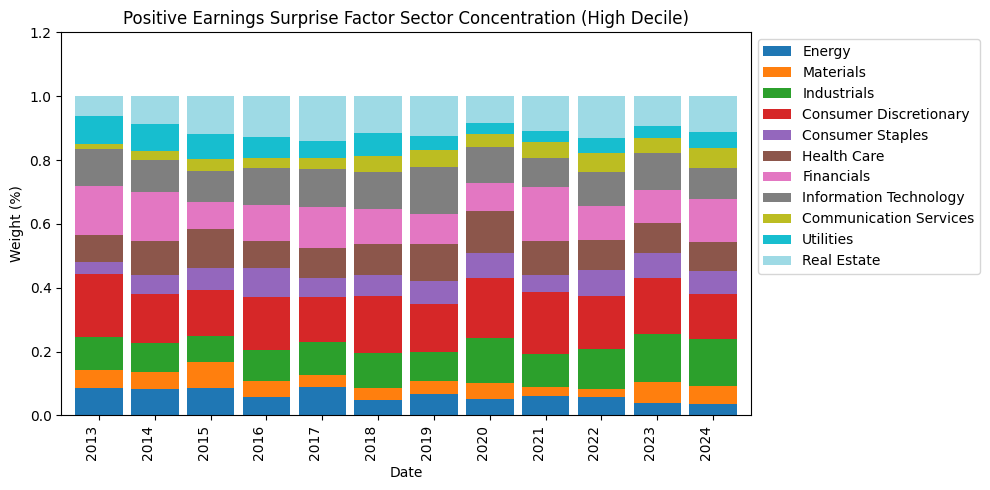

In [39]:
# Replace NaN with 0 for proper plotting
top_20_sector_distribution = top_20_sector_distribution.fillna(0)


top_20_sector_distribution_annual = top_20_sector_distribution.resample('YE').mean()
# Plotting the stacked bar chart
fig, ax = plt.subplots(figsize=(10, 5))

# Plot each sector as a stack on top of each other
top_20_sector_distribution_annual.plot(kind='bar', stacked=True, ax=ax, width=0.85, cmap="tab20")

# Formatting the plot

ax.set_xlabel('Date')
ax.set_ylabel('Weight (%)')
ax.set_title('Positive Earnings Surprise Factor Sector Concentration (High Decile)')

# Set the y-axis limits to 120% as per your example
ax.set_ylim(0, 1.2)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=90, ha='right')  # Rotate labels for readability
ax.set_xticklabels(top_20_sector_distribution_annual.index.year, rotation=90, ha='right')  # Use year labels and rotate

# Add a legend and position it outside the chart
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

# Display the plot
plt.tight_layout()
plt.show()